# Project 1 Revisited - Part 2: Global Explanations


#### Project 1 Revisited - Part 2: Global Explanations

- Create a new notebook for this assignment in your project 1 repository. Name the notebook "Explaining Models with Shap.ipynb"
- In your notebook, load the contents of your "best-models.joblib" file into a variable called "loaded_joblib."
- Save each object from the loaded_joblib dictionary as a separate variable in your notebook. (e.g. "X_train = loaded_joblib['X_train'])


#### Explain your tree-based model with shap:
 

- Create an X_shap and y_shap variable from your training data (use shap.sample as needed).
- Create a model explainer,
- Calculate the shap values for your model.
- Create a summary plot - with plot_type='bar':
  - In a Markdown cell below, display your saved feature importance image (that you used in your README) and compare the most important features according to SHAP vs. your original feature importances.
   - Are they the same features in both? If not, what's different?
  - Save your bar summary plot figure as a .png file inside your repository (you will need this for the final piece of this assignment - Update Your README).
- Create a second summary plot - with plot_type='dot'
  - In a markdown cell, interpret the top 3 most important features and how they influence your model's predictions.
  - Save your figure as a .png file inside your repository (you will need this for the final piece of this assignment - Update Your README).

#### Update your README.

- Insert your exported figures and corresponding interpretations from above into your README file. You should have:
  - a summary plot - bar version
    - Your comparison of most important features found by shap vs feature importance.
  - a summary plot - dot version
    - Your interpretation of the top 3 most important features and how they influence your model's predictions.

---

### Loading Imports

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as miss

from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import set_config

SEED = 321
np.random.seed(SEED)

fav_style = ('ggplot','tableau-colorblind10')
fav_context  ={'context':'notebook', 'font_scale':1.1}
plt.style.use(fav_style)
sns.set_context(**fav_context)
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'


import joblib, os

In [80]:
def evaluate_regression(model, X_train,y_train, X_test, y_test,for_slides=True): 
    """Evaluates a scikit learn regression model using r-squared and RMSE
    FOR SLIDES VERS DOES MULTIPLE PRINT STATEMENTS FOR VERTICAL DISPLAY OF INFO"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    mae_train = metrics.mean_absolute_error(y_train, y_pred_train)
    

    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    mae_test = metrics.mean_absolute_error(y_test, y_pred_test)
    
    if for_slides:
        df_version =[['Split','R^2','MAE','RMSE']]
        df_version.append(['Train',r2_train, mae_train, rmse_train])
        df_version.append(['Test',r2_test, mae_test, rmse_test])
        df_results = pd.DataFrame(df_version[1:], columns=df_version[0])
        df_results = df_results.round(2)
        display(df_results.style.hide(axis='index').format(precision=2, thousands=','))
        
    else: 
        print(f"Training Data:\tR^2 = {r2_train:,.2f}\tRMSE = {rmse_train:,.2f}\tMAE = {mae_train:,.2f}")
        print(f"Test Data:\tR^2 = {r2_test:,.2f}\tRMSE = {rmse_test:,.2f}\tMAE = {mae_test:,.2f}")

def get_coefficients(lin_reg):
    coeffs = pd.Series(lin_reg.coef_, index= lin_reg.feature_names_in_)
    coeffs.loc['intercept'] = lin_reg.intercept_
    return coeffs

def plot_coefficients(coeffs, sort_values=True, top_n=None, figsize=(6,4),
                     title="Linear Regression Coefficients", xlabel='Coefficient'):
    """Plots a Series of coefficients as horizotal bar chart, with option to sort
    and to only keep top_n coefficients"""
        
    if top_n is not None:
        top_n = coeffs.abs().rank().sort_values(ascending=False).head(top_n)
        coeffs = coeffs.loc[top_n.index]
        
    if sort_values:
        coeffs = coeffs.sort_values()

        
        
    ax = coeffs.plot(kind='barh', figsize=figsize)
    ax.axvline(0, color='k')
    ax.set(xlabel=xlabel, title=title);
    plt.show()
    return ax


def get_importances(rf_reg):
    importances = pd.Series(rf_reg.feature_importances_, index= rf_reg.feature_names_in_)
    return importances


def plot_importances(importances, sort_values=True, top_n=None, figsize=(6,4),
                     title="Feature Importance", xlabel='Importance'):
    if sort_values:
        importances = importances.sort_values()
        
    if top_n is not None:
        importances = importances.tail(top_n)
        
        
    ax = importances.plot(kind='barh', figsize=figsize)
    ax.axvline(0, color='k')
    ax.set(xlabel=xlabel, title=title);
    plt.show()
    return ax

## Loading Objects from Joblib

In [81]:
import joblib

In [82]:
fname = "../Models/project1-revisited-importance.joblib"

loaded = joblib.load(fname)
loaded.keys()

dict_keys(['X_train', 'X_test', 'y_train', 'y_test', 'preprocessor', 'RandomForestRegressor', 'LinearRegression'])

In [83]:
X_train = loaded['X_train']
X_test = loaded['X_test']
y_train = loaded['y_train']
y_test = loaded['y_test']

preprocessor = loaded['preprocessor']
lin_reg_final = loaded['LinearRegression']
rf_reg = loaded['RandomForestRegressor']

X_train.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
8269,7.220,Regular,0.064142,Baking Goods,61.2510,OUT010,1998,Unknown,Tier 3,Grocery Store
7604,6.135,Low Fat,0.079294,Soft Drinks,111.2860,OUT018,2009,Medium,Tier 3,Supermarket Type2
2762,12.150,Low Fat,0.028593,Household,151.0708,OUT035,2004,Small,Tier 2,Supermarket Type1
6464,5.945,Low Fat,0.093009,Household,127.8652,OUT035,2004,Small,Tier 2,Supermarket Type1
4707,18.200,Regular,0.066285,Fruits and Vegetables,247.2092,OUT035,2004,Small,Tier 2,Supermarket Type1


In [84]:
X_train_proc = preprocessor.transform(X_train)

X_test_proc = preprocessor.transform(X_test)

In [85]:
evaluate_regression(lin_reg_final, X_train_proc,y_train, X_test_proc, y_test)

Split,R^2,MAE,RMSE
Train,0.56,826.79,"1,114.98"
Test,0.56,859.97,"1,164.41"


#### We will need to do some preprocessing before we continue with our models. 

In [92]:
cat_sel = make_column_selector(dtype_include='object')
num_sel = make_column_selector(dtype_include='number')

cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),                         
                                     OneHotEncoder(drop='if_binary', sparse=False))

num_pipe = make_pipeline(SimpleImputer(strategy='mean'))

preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),
                                      verbose_feature_names_out=False)

preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                           columns = feature_names, index = X_train.index)
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                           columns = feature_names, index = X_test.index)
X_test_df.head(5)


,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,...,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Size_Unknown,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
8077,15.250000,0.061531,132.2968,2007.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2391,17.850000,0.044463,127.1020,1997.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
163,7.270000,0.071078,114.2518,1997.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4608,12.822634,0.075142,145.8444,1985.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
5544,13.500000,0.121633,161.6920,1998.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


### Importing & Applying SHAP 

In [87]:
import shap
shap.initjs()

In [107]:
X_shap = shap.sample(X_train_df,nsamples=500, random_state=SEED)
X_shap.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,...,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Size_Unknown,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
4469,7.72,0.074669,76.3986,1987.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4438,5.11,0.034868,163.8210,2004.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
366,8.05,0.078386,256.4646,2004.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2219,8.76,0.050131,128.3336,1999.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
6080,6.59,0.176748,82.7908,1998.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [108]:
y_shap = y_train.loc[X_shap.index]
y_shap

4469    1402.1748
4438    2120.5730
366     5153.2920
2219    2556.6720
6080      83.8908
          ...    
6181    4844.3608
717     1810.9760
6789    5932.2780
3608     302.9390
2472     188.4214
Name: Item_Outlet_Sales, Length: 500, dtype: float64

### Create SHAP Explainer

In [95]:
explainer = shap.Explainer(rf_reg)
shap_values = explainer(X_shap)

In [96]:
shap_values.shape

(500, 42)

In [98]:
shap_values[0]

.values =
array([ 6.48869043e+01,  3.55796496e+01, -9.52627087e+02, -5.68364281e+01,
        2.32307946e+01, -4.28985056e+00,  2.08636831e+01,  2.49786241e-01,
       -4.89211500e+00, -8.29768097e-01,  2.85287304e-01,  2.35990603e+00,
       -1.70572523e-01,  1.14822887e+00,  3.86512377e+00,  5.11119557e-02,
       -9.62884349e-01, -2.82329804e-01, -2.42516449e+00, -8.96463951e-01,
       -3.69846736e-01,  1.15370029e-02, -6.56598222e-01, -4.37920670e+00,
        1.37636670e+00, -4.87309061e-02, -4.41641830e+01, -3.77939726e+00,
        2.68034345e+00,  8.99323454e-01, -2.64735944e+00, -7.79338054e-01,
        2.99102906e+00, -3.32836418e+00, -2.14616038e+00, -4.47725113e+00,
       -1.72277610e+01, -2.76902203e+01,  2.07857057e+02,  3.19293212e+00,
        6.79212528e-01, -3.81944863e+01])

.base_values =
array([2154.71233664])

.data =
array([7.7200000e+00, 7.4669288e-02, 7.6398600e+01, 1.9870000e+03,
       1.0000000e+00, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00,
       0.0000000

In [99]:
## Create an explainer for the lin_reg
linreg_explainer = shap.Explainer(lin_reg_final, X_shap) #Leave out X_shap in lecture

## get shap values for linreg
linreg_shap_values = linreg_explainer(X_shap)
linreg_shap_values.shape

(500, 42)

## Create a Summary Bar Plot - Random Forest

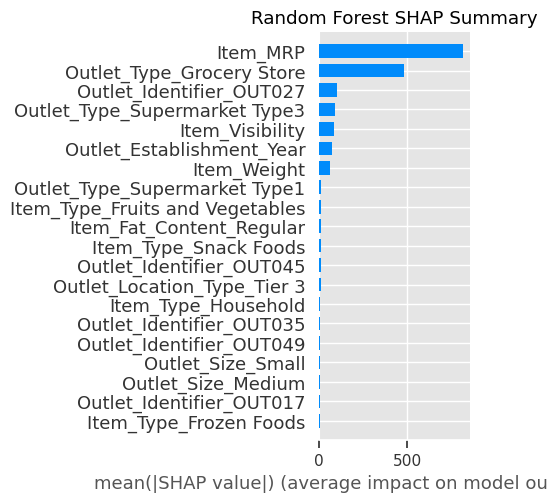

In [102]:
shap.summary_plot(shap_values, features = X_shap, plot_type='bar',
                 show=False, plot_size=[5,5])

plt.title('Random Forest SHAP Summary');

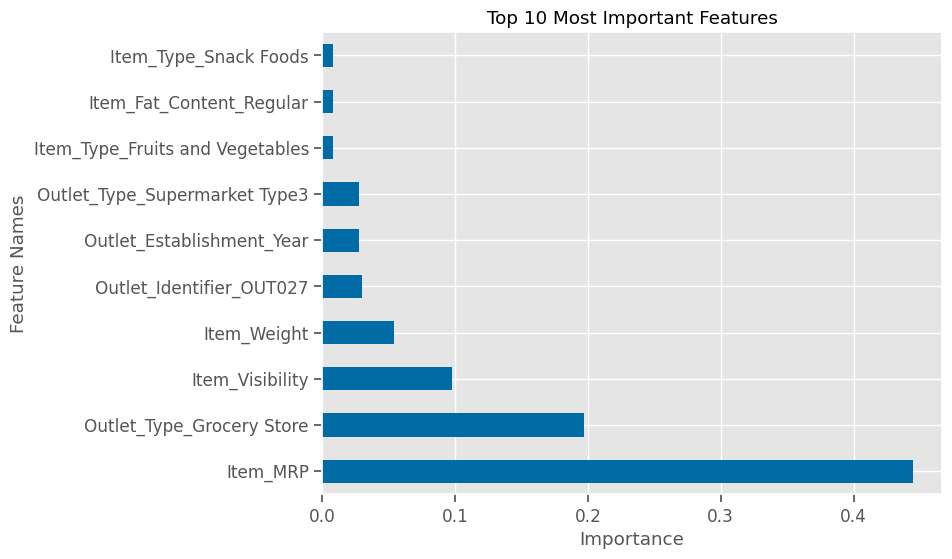

#### We can see that our random forest bar plot has similar features to our top 10 important features. Item_MRP and Outlet_type  

### Summary Bar Plot Linear Regression Model 

Text(0.5, 1.0, 'Linear Regression SHAP Summary')

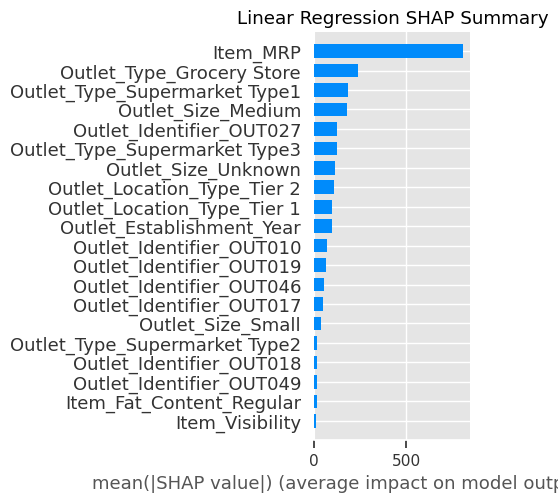

In [103]:
shap.summary_plot(linreg_shap_values, features = X_shap, plot_type='bar',
                 show=False, plot_size=[5,5])

plt.title('Linear Regression SHAP Summary')

#### We will compare Random Forest Model to our top 10 features summary  model. 

## Create a Summary Dot Plot

#### SHAP Random Forest Dot Plot Model

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


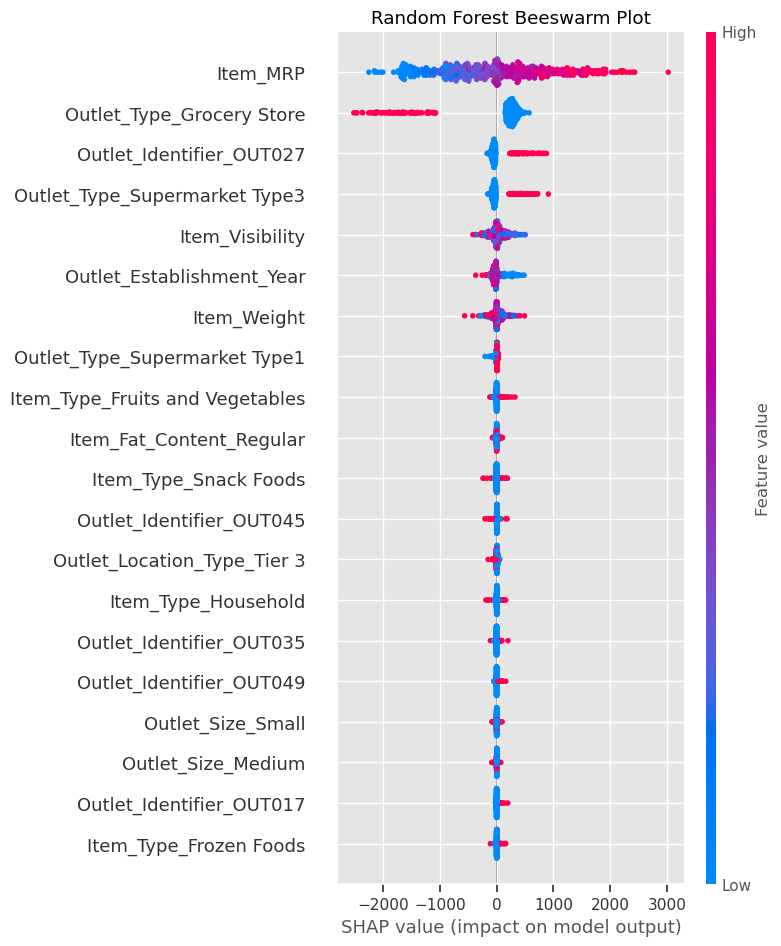

In [105]:
shap.summary_plot(shap_values, features=X_shap, show=False)

plt.title('Random Forest Beeswarm Plot')
plt.show();

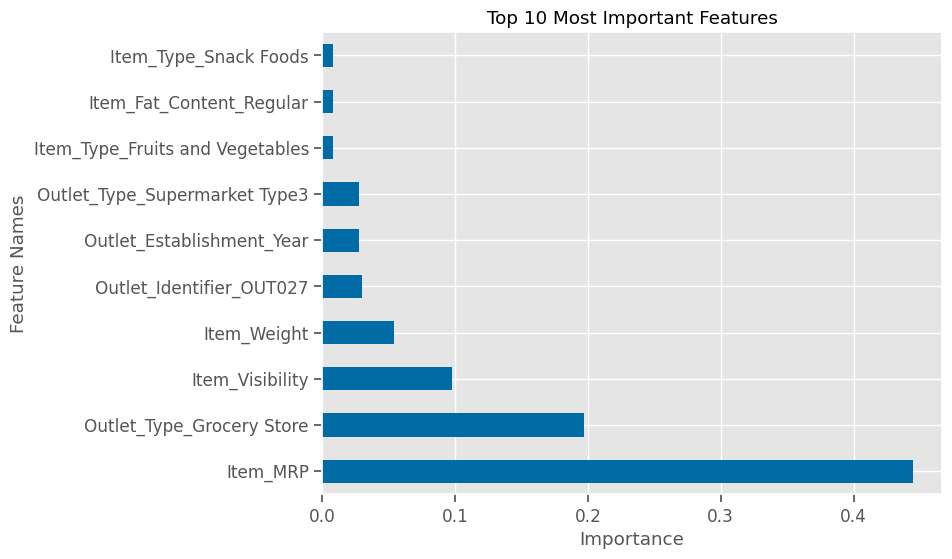

#### We will also run a Summary Plot for Linear Regression Model for further comparison.

#### Ultimately we will chose to use the 'Random Forest Model Dot plot as we have a better representation of our data. 

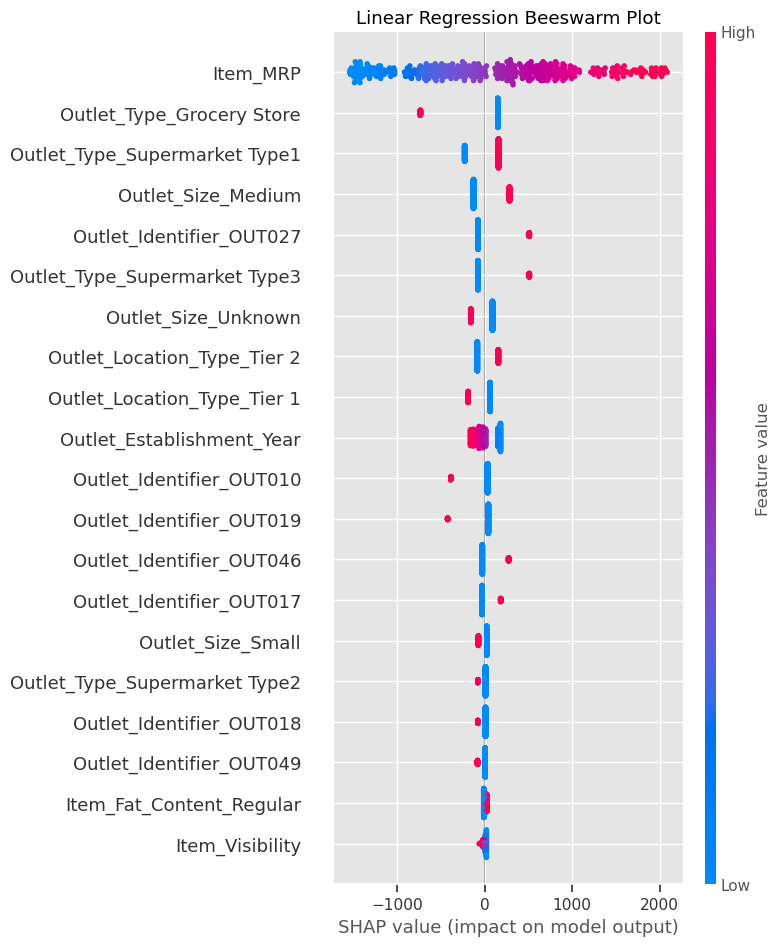

In [106]:
shap.summary_plot(linreg_shap_values, features = X_shap, show=False)
plt.title('Linear Regression Beeswarm Plot');